# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Ventilation Rates and Pollutant Concentrations
After having estimated ventilation rates using the constant and decay methods, we can perhaps see how the concentration of pollutants varies according to the ventilation rates. 

## Package Import

In [13]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Data Import

In [14]:
data_dir = "../data"
study = "utx000"
suffix = "ux_s20"

## Beacon Data
Here we import:
* `beacon_all`: All beacon data from the study
* `beacon_nightly`: Beacon data from just the evenings when we have Fitbit and GPS traces

In [15]:
beacon_all = pd.read_csv(f'{data_dir}/processed/beacon-{suffix}.csv',
                    index_col="timestamp",parse_dates=True,infer_datetime_format=True)
beacon_all.head()

,tvoc,lux,no2,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap
timestamp,,,,,,,,,,,,,,,,,
2020-06-08 13:00:00,81.2,2.77440,0.775262,13.9663,NaN,11.900343,11.320369,11.075540,0.733881,1.149634,1.935875,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:02:00,82.8,2.77440,0.798162,13.9555,NaN,12.730011,12.184753,11.910685,0.800211,1.198782,1.979986,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:04:00,84.2,2.77440,0.770355,13.8341,NaN,13.183286,12.706129,12.422126,0.840419,1.234695,2.013414,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:06:00,82.0,2.77440,0.780169,14.0344,NaN,12.301532,11.367415,11.062862,0.735991,1.104990,1.886775,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:08:00,86.6,4.07184,0.781805,13.7661,NaN,12.932402,11.947330,11.611038,0.780179,1.128095,1.905629,27.5,47.05,1,kyj367pi,24,10


In [16]:
beacon_nightly = pd.read_csv('../data/processed/beacon-fb_and_gps_filtered-ux_s20.csv',
                    index_col="timestamp",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)
beacon_nightly.head()

,lat,long,altitude,accuracy,tvoc,lux,no2,co,co2,pm1_number,...,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap,start_time,end_time
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-08-10 05:10:00,30.58838,-97.42591,113.98145,5.29684,184.700000,2.04,NaN,10.742600,1816.486399,0.145358,...,0.891251,1.901793,24.0,33.183333,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,164.000000,2.04,NaN,10.678200,1795.248136,0.178794,...,0.903066,1.919541,24.0,33.000000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,152.433333,2.04,NaN,10.676133,1763.231375,0.186363,...,0.847057,1.861326,24.0,33.000000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,159.150000,2.04,NaN,10.703900,1724.723961,NaN,...,0.808707,1.833923,24.0,33.050000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,143.933333,2.04,NaN,10.667433,1772.028385,1.646941,...,0.947046,1.964887,24.0,32.983333,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30


### Participants in the Nightly Data
For other purposes, it is worthwhile to see which participants had `beacon_nightly` data.

In [17]:
beacon_nightly["beiwe"].value_counts()

qh34m4r9    4559
tmexej5v    2999
tlmlq19s    2568
awa8uces    2338
9jtzsuu8    2030
4i7679py    1863
olaxadz5    1639
kyj367pi    1527
vr9j5rry    1052
lkkjddam    1022
745vq78e     922
xlw5ntd5     907
9xmhtq74     644
xdbdrk6e     461
rnse61g4     277
e73a1pd5     206
hxj6brwj      89
Name: beiwe, dtype: int64

## Ventilation Rates
Now the ventilation rates are imported. We import all available data, but primarily care about the last dataset:
* `ach_from_ss`: ventilation from steady-state analysis
* `ach_from_decay`: ventilation from decay method analysis
* `ach`: previous two datasets combined with less information

In [18]:
ach_from_ss = pd.read_csv(f"../data/processed/beacon-ventilation_from_ss.csv")
ach_from_decay = pd.read_csv(f"../data/processed/beacon-ventilation_from_decay.csv")
ach = pd.read_csv(f"../data/processed/beacon-ventilation.csv",parse_dates=["start","end"],infer_datetime_format=True)
ach.head()

,beacon,beiwe,start,end,ach,method
0,21.0,lkkjddam,2020-08-12 13:16:00,2020-08-12 13:38:00,0.151,decay
1,21.0,lkkjddam,2020-08-16 13:36:00,2020-08-16 14:08:00,0.143,decay
2,21.0,lkkjddam,2020-08-18 12:48:00,2020-08-18 13:22:00,0.202,decay
3,21.0,lkkjddam,2020-08-20 12:26:00,2020-08-20 12:52:00,0.078,decay
4,21.0,lkkjddam,2020-08-20 14:14:00,2020-08-20 14:44:00,0.062,decay


# Analysis
The cells below are an attempt to analysis the pollution profiles in relation to the ventilation.

## Pollutant Mean During Ventilation Estimation Period
Can't get more specific than that.

### Building the DataFrame

In [19]:
def get_pollutant_profile(ach_estimate, beacon_data):
    """"""
    # pre-allocating dictionary
    data = {"beiwe":[],"start":[],"end":[],"n":[],"ach":[],"tvoc":[],"lux":[],"no2":[],"co":[],"co2":[],"pm2p5_mass":[],"temperature_c":[],"rh":[]}
    # looping through participants
    for pt in ach_estimate["beiwe"].unique():
        # data by participant
        ach_by_pt = ach_estimate[ach_estimate["beiwe"] == pt]
        beacon_by_pt = beacon_data[beacon_data["beiwe"] == pt]
        # looping through ventilation estimation periods
        for s, e, ach in zip(ach_by_pt["start"], ach_by_pt["end"], ach_by_pt["ach"]):
            # beacon data by period
            beacon_by_period = beacon_by_pt[pd.to_datetime(s):pd.to_datetime(e)]
            # adding informational data to dictionary
            data["start"].append(s)
            data["end"].append(e)
            data["beiwe"].append(pt)
            data["n"].append(len(beacon_by_period))
            # adding ventilation (ach) and beacon aggregates 
            data["ach"].append(ach)
            for key in data.keys():
                if key not in ["beiwe","ach","n","start","end"]:
                    data[key].append(np.nanmean(beacon_by_period[key]))
        
    return pd.DataFrame(data=data)

<div class="alert alert-block alert-warning">
    
As a reminder, the decay ventilation rates are calculated using data from periods _after_ the participant has woken up. So rather than pull pollution data from the Fitbit and GPS beacon dataframe, we should use the `beacon_all` dataframe. This dataframe will still be fine for the constant period since `beacon_all` encompasses `beacon_nightly`. 
    
</div>

In [20]:
pollution_and_ach = get_pollutant_profile(ach,beacon_all)

### Visualizing

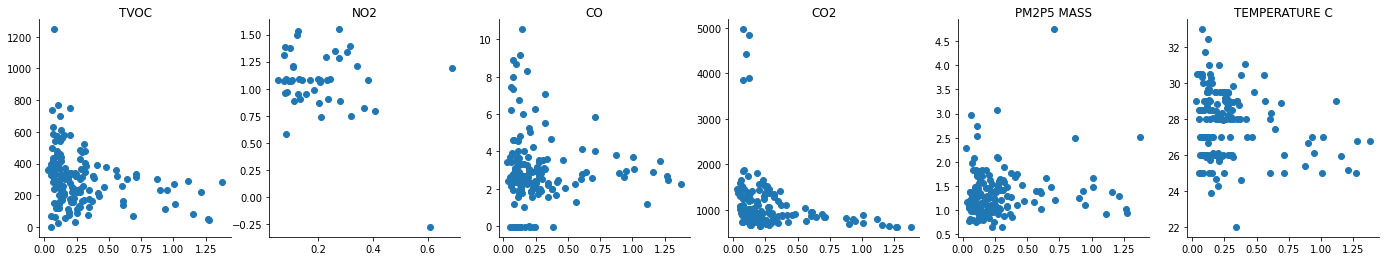

In [21]:
fig, axes = plt.subplots(1,6,figsize=(24,4))
for pollutant, ax in zip(["tvoc","no2","co","co2","pm2p5_mass","temperature_c"],axes.flat):
    ax.scatter(pollution_and_ach["ach"],pollution_and_ach[pollutant])
    for loc in ["right","top"]:
        ax.spines[loc].set_visible(False)
    ax.set_title(pollutant.upper().replace("_"," "),pad=0)
    
plt.show()
plt.close()

<div class="alert alert-block alert-success">
    
There appears to be a relationship between pollutants like `tvoc`, `co`, and `co2` and the ventilation rate. There could be something more if we eliminate some low concentration nights because there are points concentration in the lower left for most of the pollutants.
    
</div>